# Capstone Project - Battle of Neighborhoods Final

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Download and explor the data set

First, I downloaded the files and placed it on the server, so I can simply run a wget command and access the data of New York City.

In [7]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Next, let's load the data.

In [9]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Notice how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [10]:
neighborhoods_data = newyork_data['features']


Let's take a look at the first item in this list.

In [11]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

The next task is essentially transforming this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [12]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [13]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [15]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [16]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


 Let's segment and cluster only the neighborhoods in Brooklyn. So let's slice the original dataframe and create a new dataframe of the Brooklyn data.

In [17]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Let's get the geographical coordinates of Brooklyn.

In [18]:
address = 'Brooklyn, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


Let's visualize Brooklyn neighborhoods in it.

In [19]:
# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [20]:
CLIENT_ID = '5P1DXXGFSTOZZECQH5ERYPU5QCSPS4TLZLB3RVDP0ZUFX44X' 
CLIENT_SECRET = 'R3BWO10QD5LLTUVL4BJXDERK3EZIYJ3O2GQPTM1UJFLNHBHP' 
VERSION = '20180605' # Foursquare API version
LIMIT = 50

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 5P1DXXGFSTOZZECQH5ERYPU5QCSPS4TLZLB3RVDP0ZUFX44X
CLIENT_SECRET:R3BWO10QD5LLTUVL4BJXDERK3EZIYJ3O2GQPTM1UJFLNHBHP


Let's create a function to explore all neighborhoods in Brooklyn.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called brooklyn_venues.

In [22]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heig

Let's check the size of the resulting dataframe.

In [23]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(4182, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,The Bookmark Shoppe,40.624577,-74.030562,Bookstore


Let's visualize the venue data using the bar plot.

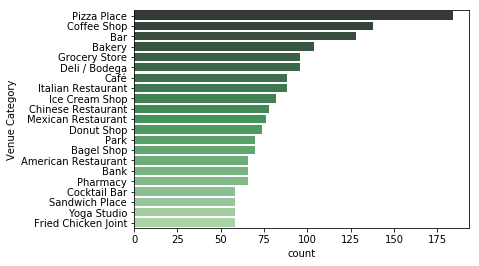

In [25]:
import seaborn as sns
sns.countplot(y="Venue Category", data=brooklyn_venues, palette="Greens_d",
              order=brooklyn_venues['Venue Category'].value_counts().iloc[:21].index)


In [26]:
brooklyn_venues['Venue Category'].value_counts()

Pizza Place                                 184
Coffee Shop                                 138
Bar                                         128
Bakery                                      104
Grocery Store                                96
Deli / Bodega                                96
Café                                         88
Italian Restaurant                           88
Ice Cream Shop                               82
Chinese Restaurant                           78
Mexican Restaurant                           76
Donut Shop                                   74
Park                                         70
Bagel Shop                                   70
American Restaurant                          66
Bank                                         66
Pharmacy                                     66
Cocktail Bar                                 58
Sandwich Place                               58
Yoga Studio                                  58
Fried Chicken Joint                     

# Analyze each neighborhood

In [27]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

print(brooklyn_onehot.shape)
brooklyn_onehot.head()

(4182, 263)


,Yoga Studio,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [28]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Bath Beach,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.020000,0.020000,0.020000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00

Let's write a function to sort the venues in descending order.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Pharmacy,Gas Station,Bubble Tea Shop,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,Check Cashing Service,Kebab Restaurant,Sports Bar
1,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Chinese Restaurant,Greek Restaurant,Grocery Store,Ice Cream Shop,Hookah Bar,American Restaurant,Lounge
2,Bedford Stuyvesant,Pizza Place,Coffee Shop,Café,Bar,Fried Chicken Joint,Bagel Shop,Cocktail Bar,Gift Shop,Gourmet Shop,Boutique
3,Bensonhurst,Sushi Restaurant,Bakery,Ice Cream Shop,Chinese Restaurant,Italian Restaurant,Donut Shop,Factory,Road,Noodle House,Liquor Store
4,Bergen Beach,Harbor / Marina,Baseball Field,Athletics & Sports,Playground,Donut Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


# Cluster neighborhoods


Run k-means to cluster the neighborhood into 3 clusters.

In [32]:
# set number of clusters
kclusters = 3

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 2, 0, 2, 2, 2, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn_data

# merge brooklyn_grouped with brooklyn_data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0,Spa,Italian Restaurant,Pizza Place,Chinese Restaurant,Greek Restaurant,Grocery Store,Ice Cream Shop,Hookah Bar,American Restaurant,Lounge
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0,Sushi Restaurant,Bakery,Ice Cream Shop,Chinese Restaurant,Italian Restaurant,Donut Shop,Factory,Road,Noodle House,Liquor Store
2,Brooklyn,Sunset Park,40.645103,-74.010316,2,Bank,Latin American Restaurant,Pizza Place,Bakery,Mexican Restaurant,Gym,Fried Chicken Joint,Pharmacy,Deli / Bodega,Mobile Phone Shop
3,Brooklyn,Greenpoint,40.730201,-73.954241,0,Coffee Shop,Bar,Cocktail Bar,Yoga Studio,Spa,Café,Bakery,Record Shop,Pizza Place,French Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,2,Pizza Place,Bakery,Bus Station,Lounge,Diner,Chinese Restaurant,Breakfast Spot,Furniture / Home Store,Bar,Electronics Store


Finally, let's visualize the resulting clusters.

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine clusters

Now, I can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. 

# Cluster 1

In [66]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(3, brooklyn_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,-74.030621,0,Spa,Italian Restaurant,Pizza Place,Chinese Restaurant,Greek Restaurant,Grocery Store,Ice Cream Shop,Hookah Bar,American Restaurant,Lounge
1,Bensonhurst,-73.995180,0,Sushi Restaurant,Bakery,Ice Cream Shop,Chinese Restaurant,Italian Restaurant,Donut Shop,Factory,Road,Noodle House,Liquor Store
3,Greenpoint,-73.954241,0,Coffee Shop,Bar,Cocktail Bar,Yoga Studio,Spa,Café,Bakery,Record Shop,Pizza Place,French Restaurant
6,Sheepshead Bay,-73.943186,0,Dessert Shop,Turkish Restaurant,Sandwich Place,Harbor / Marina,Yoga Studio,Grocery Store,Hotel,Creperie,Restaurant,Outlet Store
12,Windsor Terrace,-73.980073,0,Deli / Bodega,Café,Diner,Park,Plaza,Bakery,Coffee Shop,Sushi Restaurant,Chinese Restaurant,Beer Store
13,Prospect Heights,-73.964859,0,Bar,Mexican Restaurant,Cocktail Bar,Beer Bar,Coffee Shop,Wine Bar,Café,Thai Restaurant,Bakery,Ice Cream Shop
15,Williamsburg,-73.958115,0,Coffee Shop,Bar,Bagel Shop,Yoga Studio,Taco Place,Breakfast Spot,Burger Joint,Café,Clothing Store,Playground
16,Bushwick,-73.925258,0,Bar,Mexican Restaurant,Coffee Shop,Bakery,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Discount Store,Pizza Place,Residential Building (Apartment / Condo),Korean Restaurant
17,Bedford Stuyvesant,-73.941785,0,Pizza Place,Coffee Shop,Café,Bar,Fried Chicken Joint,Bagel Shop,Cocktail Bar,Gift Shop,Gourmet Shop,Boutique
18,Brooklyn Heights,-73.993782,0,Yoga Studio,Park,Italian Restaurant,Deli / Bodega,Pet Store,Mexican Restaurant,Scenic Lookout,Ice Cream Shop,Wine Shop,Gym


# Cluster 2

In [67]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(3, brooklyn_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Mill Island,-73.908186,1,Pool,Locksmith,Women's Store,Filipino Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop
100,Mill Island,-73.908186,1,Pool,Locksmith,Women's Store,Filipino Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop


# Cluster 3

In [68]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(3, brooklyn_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Sunset Park,-74.010316,2,Bank,Latin American Restaurant,Pizza Place,Bakery,Mexican Restaurant,Gym,Fried Chicken Joint,Pharmacy,Deli / Bodega,Mobile Phone Shop
4,Gravesend,-73.973471,2,Pizza Place,Bakery,Bus Station,Lounge,Diner,Chinese Restaurant,Breakfast Spot,Furniture / Home Store,Bar,Electronics Store
5,Brighton Beach,-73.965094,2,Restaurant,Russian Restaurant,Beach,Eastern European Restaurant,Gourmet Shop,Sushi Restaurant,Bank,Mobile Phone Shop,Taco Place,Korean Restaurant
7,Manhattan Terrace,-73.957438,2,Pizza Place,Donut Shop,Ice Cream Shop,Steakhouse,Coffee Shop,Grocery Store,Convenience Store,Restaurant,Bank,Cosmetics Shop
8,Flatbush,-73.958401,2,Mexican Restaurant,Coffee Shop,Juice Bar,Bank,Caribbean Restaurant,Pizza Place,Lounge,Chinese Restaurant,Bagel Shop,Sandwich Place
9,Crown Heights,-73.943291,2,Pizza Place,Café,Museum,Bakery,Pharmacy,Coffee Shop,Salon / Barbershop,Candy Store,Burger Joint,Playground
10,East Flatbush,-73.936103,2,Print Shop,Hardware Store,Department Store,Moving Target,Supermarket,Fast Food Restaurant,Caribbean Restaurant,Park,Chinese Restaurant,Food & Drink Shop
11,Kensington,-73.980421,2,Thai Restaurant,Grocery Store,Mexican Restaurant,Ice Cream Shop,Pizza Place,Supermarket,Mobile Phone Shop,Furniture / Home Store,Coffee Shop,Taco Place
14,Brownsville,-73.910235,2,Moving Target,Restaurant,Chinese Restaurant,Park,Fried Chicken Joint,Playground,Pizza Place,Spanish Restaurant,Discount Store,Performing Arts Venue
25,Cypress Hills,-73.876616,2,Fried Chicken Joint,Ice Cream Shop,Donut Shop,Fast Food Restaurant,Spanish Restaurant,Latin American Restaurant,Mexican Restaurant,Baseball Field,Discount Store,Chinese Restaurant


# Now I work on the dataset of Toronto City

Download the data, scrap the webpage and transform the data into pandas dataframe.

In [38]:
from bs4 import BeautifulSoup
import lxml

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
canada_df = BeautifulSoup(source, 'lxml')

In [39]:
#define the column names
column_names = ['Postal Code','Borough','Neighborhood']

#instantiate the dataframe
Toronto = pd.DataFrame(columns = column_names)


content = canada_df.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n').replace('\n', ',')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n').replace('\n', ',')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace('/', ',')
    Toronto = Toronto.append({'Postal Code': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

# clean dataframe 
Toronto = Toronto[Toronto.Borough!='Not assigned']
Toronto = Toronto[Toronto.Borough!= 0]
Toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,Toronto.shape[0]):
    if Toronto.iloc[i][2] == 'Not assigned':
        Toronto.iloc[i][2] = Toronto.iloc[i][1]
        i = i+1
                                 
df = Toronto.groupby(['Postal Code','Borough'])['Neighborhood'].apply(','.join).reset_index()

df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [40]:
geo_csv = 'https://cocl.us/Geospatial_data'
df_geo = pd.read_csv(geo_csv)
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [42]:
df_geonew = pd.merge(df_geo, df)
df_geonew.head()

,Postal Code,Latitude,Longitude,Borough,Neighborhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [43]:
df_geonew = df_geonew[['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
df_geonew.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Let's segment and cluster only the neighborhoods in York. So let's slice the original dataframe and create a new dataframe of the York data.

In [47]:
#slice the original dataframe and create a new dataframe of the York data.
toronto_data = df_geonew[df_geonew['Borough'] == 'York'].reset_index(drop=True)
print(toronto_data.shape)
toronto_data.head()

(5, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M6C,York,Humewood-Cedarvale,43.693781,-79.428191
1,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512
2,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013
3,M6N,York,"Runnymede, The Junction North",43.673185,-79.487262
4,M9N,York,Weston,43.706876,-79.518188


Let's get the geographical coordinates of York.

In [48]:
address = 'York, Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of York are 43.67910515, -79.49118414007154.


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


Let's visualize York neighborhoods in it.

In [49]:
# create map of Torontousing latitude and longitude values
!pip install folium
import folium

map_york = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_york)  
    
map_york

Next, I am going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [50]:
CLIENT_ID = '5P1DXXGFSTOZZECQH5ERYPU5QCSPS4TLZLB3RVDP0ZUFX44X' # your Foursquare ID
CLIENT_SECRET = 'R3BWO10QD5LLTUVL4BJXDERK3EZIYJ3O2GQPTM1UJFLNHBHP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5P1DXXGFSTOZZECQH5ERYPU5QCSPS4TLZLB3RVDP0ZUFX44X
CLIENT_SECRET:R3BWO10QD5LLTUVL4BJXDERK3EZIYJ3O2GQPTM1UJFLNHBHP


Let's create a function to explore all neighborhoods in York

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called york_venues.


In [52]:
york_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


Humewood-Cedarvale
Caledonia-Fairbanks
Del Ray, Mount Dennis, Keelsdale and Silverthorn
Runnymede, The Junction North
Weston


Let's check the size of the resulting dataframe.

In [53]:
print(york_venues.shape)
york_venues.head()

(17, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Humewood-Cedarvale,43.693781,-79.428191,Cedarvale Park,43.692535,-79.428705,Field
1,Humewood-Cedarvale,43.693781,-79.428191,Cedarvale Ravine,43.690188,-79.426106,Trail
2,Humewood-Cedarvale,43.693781,-79.428191,Phil White Arena,43.691303,-79.431761,Hockey Arena
3,Humewood-Cedarvale,43.693781,-79.428191,Prince's Parkette,43.697385,-79.424704,Park
4,Caledonia-Fairbanks,43.689026,-79.453512,Nairn Park,43.690654,-79.456300,Park


Let's visualize the venue data in York using bar plot.

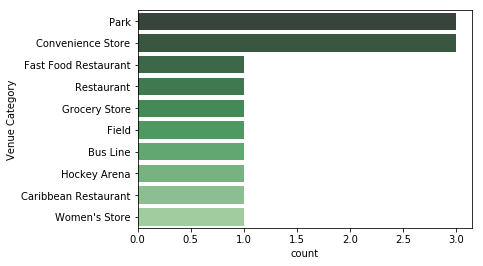

In [54]:
import seaborn as sns
sns.countplot(y="Venue Category", data=york_venues, palette="Greens_d",
              order=york_venues['Venue Category'].value_counts().iloc[:10].index)

In [55]:
york_venues['Venue Category'].value_counts()

Park                    3
Convenience Store       3
Fast Food Restaurant    1
Restaurant              1
Grocery Store           1
Field                   1
Bus Line                1
Hockey Arena            1
Caribbean Restaurant    1
Women's Store           1
Sandwich Place          1
Pool                    1
Trail                   1
Name: Venue Category, dtype: int64

# Analyze each neighborhood.

In [56]:
# one hot encoding
york_onehot = pd.get_dummies(york_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
york_onehot['Neighborhood'] = york_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [york_onehot.columns[-1]] + list(york_onehot.columns[:-1])
york_onehot = york_onehot[fixed_columns]

print(york_onehot.shape)
york_onehot.head()

(17, 14)


,Neighborhood,Bus Line,Caribbean Restaurant,Convenience Store,Fast Food Restaurant,Field,Grocery Store,Hockey Arena,Park,Pool,Restaurant,Sandwich Place,Trail,Women's Store
0,Humewood-Cedarvale,0,0,0,0,1,0,0,0,0,0,0,0,0
1,Humewood-Cedarvale,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Humewood-Cedarvale,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Humewood-Cedarvale,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Caledonia-Fairbanks,0,0,0,0,0,0,0,1,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [57]:
york_grouped = york_onehot.groupby('Neighborhood').mean().reset_index()
york_grouped.head()

,Neighborhood,Bus Line,Caribbean Restaurant,Convenience Store,Fast Food Restaurant,Field,Grocery Store,Hockey Arena,Park,Pool,Restaurant,Sandwich Place,Trail,Women's Store
0,Caledonia-Fairbanks,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.333333,0.333333,0.00,0.00,0.00,0.333333
1,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.000000,0.000000,0.25,0.25,0.00,0.000000
2,Humewood-Cedarvale,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.250000,0.000000,0.00,0.00,0.25,0.000000
3,"Runnymede, The Junction North",0.25,0.25,0.25,0.00,0.00,0.25,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000
4,Weston,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.500000,0.000000,0.00,0.00,0.00,0.000000


 Let's write a function to sort the venues in descending order.

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = york_grouped['Neighborhood']

for ind in np.arange(york_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(york_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Caledonia-Fairbanks,Women's Store,Pool,Park,Trail,Sandwich Place,Restaurant,Hockey Arena,Grocery Store,Field,Fast Food Restaurant
1,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Sandwich Place,Restaurant,Fast Food Restaurant,Convenience Store,Women's Store,Trail,Pool,Park,Hockey Arena,Grocery Store
2,Humewood-Cedarvale,Trail,Park,Hockey Arena,Field,Women's Store,Sandwich Place,Restaurant,Pool,Grocery Store,Fast Food Restaurant
3,"Runnymede, The Junction North",Grocery Store,Convenience Store,Caribbean Restaurant,Bus Line,Women's Store,Trail,Sandwich Place,Restaurant,Pool,Park
4,Weston,Park,Convenience Store,Women's Store,Trail,Sandwich Place,Restaurant,Pool,Hockey Arena,Grocery Store,Field


# Cluster Neighborhoods

In [ ]:
Run k-means to cluster the neighborhood into 3 clusters.

In [60]:
# set number of clusters
kclusters = 3

york_grouped_clustering = york_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(york_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 1, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

york_merged = toronto_data

# merge york_grouped with york_data to add latitude/longitude for each neighborhood
york_merged = york_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

york_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,2,Trail,Park,Hockey Arena,Field,Women's Store,Sandwich Place,Restaurant,Pool,Grocery Store,Fast Food Restaurant
1,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,2,Women's Store,Pool,Park,Trail,Sandwich Place,Restaurant,Hockey Arena,Grocery Store,Field,Fast Food Restaurant
2,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,1,Sandwich Place,Restaurant,Fast Food Restaurant,Convenience Store,Women's Store,Trail,Pool,Park,Hockey Arena,Grocery Store
3,M6N,York,"Runnymede, The Junction North",43.673185,-79.487262,1,Grocery Store,Convenience Store,Caribbean Restaurant,Bus Line,Women's Store,Trail,Sandwich Place,Restaurant,Pool,Park
4,M9N,York,Weston,43.706876,-79.518188,0,Park,Convenience Store,Women's Store,Trail,Sandwich Place,Restaurant,Pool,Hockey Arena,Grocery Store,Field



Finally, let's visualize the resulting clusters.

In [62]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(york_merged['Latitude'], york_merged['Longitude'], york_merged['Neighborhood'], york_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

Now, I can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster.

# Cluster 1

In [69]:
york_merged.loc[york_merged['Cluster Labels'] == 0, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,York,43.706876,-79.518188,0,Park,Convenience Store,Women's Store,Trail,Sandwich Place,Restaurant,Pool,Hockey Arena,Grocery Store,Field


# Cluster 2

In [70]:
york_merged.loc[york_merged['Cluster Labels'] == 1, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,York,43.691116,-79.476013,1,Sandwich Place,Restaurant,Fast Food Restaurant,Convenience Store,Women's Store,Trail,Pool,Park,Hockey Arena,Grocery Store
3,York,43.673185,-79.487262,1,Grocery Store,Convenience Store,Caribbean Restaurant,Bus Line,Women's Store,Trail,Sandwich Place,Restaurant,Pool,Park


# Cluster 3

In [71]:
york_merged.loc[york_merged['Cluster Labels'] == 2, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,York,43.693781,-79.428191,2,Trail,Park,Hockey Arena,Field,Women's Store,Sandwich Place,Restaurant,Pool,Grocery Store,Fast Food Restaurant
1,York,43.689026,-79.453512,2,Women's Store,Pool,Park,Trail,Sandwich Place,Restaurant,Hockey Arena,Grocery Store,Field,Fast Food Restaurant
